In [1]:
# CELL 1 - Just load the model
# type this in the terminal to start virtual environment: conda activate cobra-env

import cobra
import copy
import pandas as pd
from cobra import Reaction, Metabolite

# Load the functional model
modelOG = cobra.io.read_sbml_model("../../model/iML1515.xml")  # adjust path if needed

In [2]:
# CELL 2: Test cell - resets models and tests if it is running

model = copy.deepcopy(modelOG)

# Run FBA
solution = model.optimize()

# Check results
print(f"Objective value (growth rate): {solution.objective_value:.2f}")

# Filter exchange reactions with nonzero flux
nonzero_ex_fluxes = [
    (rxn.id, solution.fluxes[rxn.id])
    for rxn in model.exchanges
    if abs(solution.fluxes[rxn.id]) > 1e-8
]

# Sort and print
nonzero_ex_fluxes.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"Nonzero exchange fluxes ({len(nonzero_ex_fluxes)} total):\n")
for rxn_id, flux in nonzero_ex_fluxes:
    print(f"{rxn_id:25s} {flux:10.3f}")

Objective value (growth rate): 0.88
Nonzero exchange fluxes (20 total):

EX_h2o_e                      47.162
EX_co2_e                      24.003
EX_o2_e                      -22.132
EX_glc__D_e                  -10.000
EX_nh4_e                      -9.471
EX_h_e                         8.058
EX_pi_e                       -0.846
EX_so4_e                      -0.221
EX_k_e                        -0.171
EX_fe2_e                      -0.014
EX_mg2_e                      -0.008
EX_ca2_e                      -0.005
EX_cl_e                       -0.005
EX_cu2_e                      -0.001
EX_mn2_e                      -0.001
EX_zn2_e                      -0.000
EX_ni2_e                      -0.000
EX_cobalt2_e                  -0.000
EX_mobd_e                     -0.000
EX_meoh_e                      0.000


In [3]:
# CELL 3: Set model parameters
# Get reaction ID
rxnGluUptk = model.reactions.get_by_id("EX_glc__D_e") # this is for glucose exchange
rxnXylUptk = model.reactions.get_by_id("EX_xyl__D_e") # this is for xylose exchange
rxnOxyUptk = model.reactions.get_by_id("EX_o2_e") # this is for xylose exchange

# Change bounds of C-source
rxnGluUptk.lower_bound = -5
rxnXylUptk.lower_bound = -5

rxnOxyUptk.lower_bound = 0


# Run FBA
solution = model.optimize()

# Check results
print(f"Objective value (growth rate): {solution.objective_value:.3f}")

# Filter exchange reactions with nonzero flux
nonzero_ex_fluxes = [
    (rxn.id, solution.fluxes[rxn.id])
    for rxn in model.exchanges
    if abs(solution.fluxes[rxn.id]) > 1e-8
]

# Sort and print
nonzero_ex_fluxes.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"Nonzero exchange fluxes ({len(nonzero_ex_fluxes)} total):\n")
for rxn_id, flux in nonzero_ex_fluxes:
    print(f"{rxn_id:25s} {flux:10.3f}")

Objective value (growth rate): 0.129
Nonzero exchange fluxes (25 total):

EX_h_e                        26.367
EX_for_e                      16.887
EX_ac_e                        8.212
EX_etoh_e                      8.143
EX_glc__D_e                   -5.000
EX_xyl__D_e                   -5.000
EX_h2o_e                      -4.752
EX_nh4_e                      -1.389
EX_pi_e                       -0.124
EX_co2_e                      -0.047
EX_succ_e                      0.043
EX_so4_e                      -0.032
EX_k_e                        -0.025
EX_mg2_e                      -0.001
EX_fe2_e                      -0.001
EX_fe3_e                      -0.001
EX_cl_e                       -0.001
EX_ca2_e                      -0.001
EX_cu2_e                      -0.000
EX_mn2_e                      -0.000
EX_zn2_e                      -0.000
EX_ni2_e                      -0.000
EX_cobalt2_e                  -0.000
EX_mobd_e                     -0.000
EX_meoh_e                      0.000


In [ ]:
# CELL 4a: List reactions to be deleted and record growth + exchange fluxes

# Make a copy of the model with pre-set bounds from previous cell
model_test = copy.deepcopy(model)

# Reaction IDs to test
test_rxns = [
    "LDH_D",
    "LDH_D2",
    "ALCD19",
    "ALCD2x",
    "FRD2",
    "FRD3",
    "PFL",    
    "ACKr",
    "XYLI1",
    "XYLK",
    "DXYLK",
    "THD2pp",
    "NADTRHD"
]


In [4]:
# CELL 4b: List reactions to be deleted and record growth + exchange fluxes

# Contains last deletion before model becomes infeasible

# Make a copy of the model with pre-set bounds from previous cell
model_test = copy.deepcopy(model)

# Reaction IDs to test
test_rxns = [
    "LDH_D",
    "LDH_D2",
    "ALCD19",
    "ALCD2x",
    "FRD2",
    "FRD3",
    "PFL",
    "ACKr",
    "XYLI1" # must be deleted to otherwise the mudel uses it despite the addition of the XR
]


In [ ]:

# OPTIONAL - to see the effect of individual deletions
# List of exchange reactions to track
exchanges_to_track = [rxn.id for rxn in model_test.exchanges]

results = []

for rxn_id in test_rxns:
    # Fresh copy for each knockout
    modelFresh = copy.deepcopy(model_test)
    rxn = modelFresh.reactions.get_by_id(rxn_id)
    rxn.knock_out()
    sol = modelFresh.optimize()
    
    # Record growth and exchange fluxes
    row = {"reaction": rxn_id, "growth_rate": round(sol.objective_value, 4)}
    for ex in exchanges_to_track:
        row[ex] = round(sol.fluxes[ex], 4)
    
    results.append(row)

# Convert to DataFrame
flux_df = pd.DataFrame(results)

# Keep only exchange columns with at least one nonzero value
flux_cols = [col for col in flux_df.columns if col.startswith("EX_")]
nonzero_cols = [col for col in flux_cols if flux_df[col].abs().sum() > 0]
flux_df = flux_df[["reaction", "growth_rate"] + nonzero_cols]

# Transpose for easier visualization
flux_df_t = flux_df.set_index("reaction").T
print(flux_df_t)


In [5]:
# CELL 5: Cumulative knockouts in listed order

# Start from the preset model
model_cumulative = copy.deepcopy(model)

# Exchange reactions to track
exchanges_to_track = [rxn.id for rxn in model_cumulative.exchanges]

results_cumulative = []

for i, rxn_id in enumerate(test_rxns, 1):
    rxn = model_cumulative.reactions.get_by_id(rxn_id)
    rxn.knock_out()
    sol = model_cumulative.optimize()

    # Safeguard against infeasible solution
    if sol.status == "optimal":
        growth = round(sol.objective_value, 4)
    else:
        growth = None  # infeasible

    row = {"step": i, "reaction": rxn_id, "growth_rate": growth}

    # Record exchange fluxes only if solution is feasible
    for ex in exchanges_to_track:
        row[ex] = round(sol.fluxes[ex], 4) if growth is not None else None

    results_cumulative.append(row)

# Convert to DataFrame
cum_df = pd.DataFrame(results_cumulative)

# Keep only exchange columns with at least one nonzero value
flux_cols = [col for col in cum_df.columns if col.startswith("EX_")]
nonzero_cols = [col for col in flux_cols if cum_df[col].abs().sum() > 0]
cum_df = cum_df[["step", "reaction", "growth_rate"] + nonzero_cols]

# Transpose for easier visualization
cum_df_t = cum_df.set_index("reaction").T
print(cum_df_t)

reaction         LDH_D   LDH_D2   ALCD19   ALCD2x     FRD2     FRD3     PFL  \
step            1.0000   2.0000   3.0000   4.0000   5.0000   6.0000  7.0000   
growth_rate     0.1286   0.1286   0.1286   0.0920   0.0920   0.0920  0.0100   
EX_pi_e        -0.1240  -0.1240  -0.1240  -0.0887  -0.0887  -0.0887 -0.0096   
EX_co2_e       -0.0472  -0.0472  -0.0472  -0.0990  -0.0338  -0.0338  9.1189   
EX_fe3_e       -0.0010  -0.0010  -0.0010  -0.0007  -0.0007  -0.0007 -0.0001   
EX_h_e         26.3674  26.3674  26.3674  26.7552  26.6900  26.6900  9.1784   
EX_mn2_e       -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001 -0.0000   
EX_ac_e         8.2124   8.2124   8.2124   4.2995   4.2669   4.2669  9.0796   
EX_succ_e       0.0429   0.0429   0.0429   0.0959   0.0307   0.0307  0.0033   
EX_fe2_e       -0.0011  -0.0011  -0.0011  -0.0008  -0.0008  -0.0008 -0.0001   
EX_glc__D_e    -5.0000  -5.0000  -5.0000  -5.0000  -5.0000  -5.0000 -5.0000   
EX_xyl__D_e    -5.0000  -5.0000  -5.0000  -5.0000  -

c:\Users\Admin\miniconda3\envs\cobra-env\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [6]:
# CELL 6: Add XYLR_var (NADH-dependent xylose reductase) and xylitol transport/exchange
from cobra import Reaction, Metabolite
import copy

# Start from the cumulative knockout model
model_var = copy.deepcopy(model_cumulative)

# === Define existing metabolites ===
xyl__D_c = model_var.metabolites.get_by_id("xyl__D_c")   # D-Xylose[c]
h_c      = model_var.metabolites.get_by_id("h_c")        # H+[c]
nadh_c   = model_var.metabolites.get_by_id("nadh_c")     # NADH[c]
nad_c    = model_var.metabolites.get_by_id("nad_c")      # NAD+[c]

# === Create new metabolite: D-Xylitol in cytoplasm ===
xylt__D_c = Metabolite(
    "xylt__D_c",
    name="D-Xylitol",
    compartment="c",
    formula="C5H12O5",
    charge=0
)
model_var.add_metabolites([xylt__D_c])

# === Add NADH-dependent xylose reductase ===
xylr_var = Reaction("XYLR_var")
xylr_var.name = "Xylose reductase (NADH-dependent)"
xylr_var.lower_bound = -1000.0
xylr_var.upper_bound = 1000.0

# D-Xylose[c] + H+[c] + NADH[c] <=> D-Xylitol[c] + NAD+[c]
xylr_var.add_metabolites({
    xyl__D_c: -1.0,
    h_c: -1.0,
    nadh_c: -1.0,
    xylt__D_c: 1.0,
    nad_c: 1.0
})

model_var.add_reactions([xylr_var])

# === Create reversible transport: D-Xylitol[c] <=> D-Xylitol[e] ===
xylt__D_e = Metabolite(
    "xylt__D_e",
    name="D-Xylitol",
    compartment="e",
    formula="C5H12O5",
    charge=0
)
model_var.add_metabolites([xylt__D_e])

xylt_trans = Reaction("XYLTt")
xylt_trans.name = "D-Xylitol transport (reversible)"
xylt_trans.lower_bound = -1000.0
xylt_trans.upper_bound = 1000.0
xylt_trans.add_metabolites({
    xylt__D_c: -1.0,
    xylt__D_e: 1.0
})
model_var.add_reactions([xylt_trans])

# === Add exchange reaction: D-Xylitol[e] <=> ===
xylt_ex = Reaction("EX_xylt__D_e")
xylt_ex.name = "D-Xylitol exchange"
xylt_ex.lower_bound = 0
xylt_ex.upper_bound = 1000.0
xylt_ex.add_metabolites({
    xylt__D_e: -1.0
})
model_var.add_reactions([xylt_ex])

# === Test model feasibility ===
sol = model_var.optimize()


# === Collect and print nonzero exchange fluxes ===
nonzero_ex_fluxes = [
    (rxn.id, sol.fluxes[rxn.id])
    for rxn in model_var.exchanges
    if abs(sol.fluxes[rxn.id]) > 1e-8
]
nonzero_ex_fluxes.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"Nonzero exchange fluxes ({len(nonzero_ex_fluxes)} total):\n")
for rxn_id, flux in nonzero_ex_fluxes:
    print(f"{rxn_id:25s} {flux:10.4f}")

    # List of added reactions
added_rxns = ["XYLR_var", "XYLTt", "EX_xylt__D_e"]


Nonzero exchange fluxes (24 total):

EX_co2_e                      9.3180
EX_xylt__D_e                  5.0000
EX_glc__D_e                  -5.0000
EX_xyl__D_e                  -5.0000
EX_h2o_e                      3.8676
EX_h_e                        3.1602
EX_hxa_e                      3.0969
EX_12ppd__R_e                 0.6123
EX_nh4_e                     -0.0654
EX_pi_e                      -0.0058
EX_ac_e                       0.0035
EX_succ_e                     0.0020
EX_so4_e                     -0.0015
EX_k_e                       -0.0012
EX_mg2_e                     -0.0001
EX_fe2_e                     -0.0000
EX_fe3_e                     -0.0000
EX_ca2_e                     -0.0000
EX_cl_e                      -0.0000
EX_cu2_e                     -0.0000
EX_mn2_e                     -0.0000
EX_zn2_e                     -0.0000
EX_ni2_e                     -0.0000
EX_cobalt2_e                 -0.0000


In [7]:
# CELL 7: Test effect of xylose uptake rate on growth

import pandas as pd
import copy

# Make a fresh copy of the model with XYLR_var already added
model_flux_test = copy.deepcopy(model_var)

# Define the xylose exchange reaction
rxnXylUptk = model_flux_test.reactions.get_by_id("EX_xyl__D_e")

# Prepare list of xylose uptake rates (0 to -10, in -1 steps)
uptake_rates = list(range(0, -11, -1))

# Store results
results = []

for rate in uptake_rates:
    # Copy model each time to avoid carry-over effects
    model_temp = copy.deepcopy(model_flux_test)
    rxn = model_temp.reactions.get_by_id("EX_xyl__D_e")
    rxn.lower_bound = rate

    # Optimize model
    sol = model_temp.optimize()

    # Record growth rate or infeasibility
    if sol.status == "optimal":
        growth = round(sol.objective_value, 4)
    else:
        growth = None  # infeasible

    results.append({"xylose_uptake": rate, "growth_rate": growth})

# Convert to DataFrame
xylose_growth_df = pd.DataFrame(results)

print("Growth rate vs xylose uptake rate:")
print(xylose_growth_df.to_string(index=False))


c:\Users\Admin\miniconda3\envs\cobra-env\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Growth rate vs xylose uptake rate:
 xylose_uptake  growth_rate
             0          NaN
            -1          NaN
            -2          NaN
            -3          NaN
            -4       0.0013
            -5       0.0061
            -6       0.0108
            -7       0.0138
            -8       0.0138
            -9       0.0138
           -10       0.0138


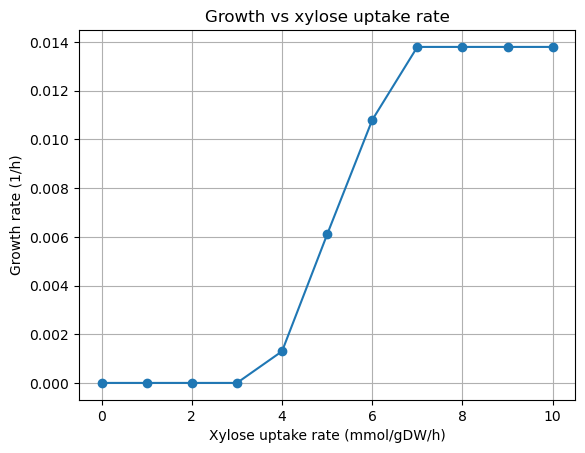

In [10]:
# CELL 8: Plot growth rate vs xylose uptake rate (positive x-axis, NaNs as zero)

import matplotlib.pyplot as plt
import pandas as pd

# Make a clean copy for plotting
plot_df = xylose_growth_df.copy()

# Invert xylose uptake signal (so positive means uptake)
plot_df["xylose_uptake"] = -plot_df["xylose_uptake"]

# Replace NaN (infeasible) growth rates with 0
plot_df["growth_rate"] = plot_df["growth_rate"].fillna(0)

# Plot
plot_df.plot(x="xylose_uptake", y="growth_rate", marker="o", legend=False)
plt.xlabel("Xylose uptake rate (mmol/gDW/h)")
plt.ylabel("Growth rate (1/h)")
plt.title("Growth vs xylose uptake rate")
plt.grid(True)
plt.show()
